In [ ]:
! pip install albumentations==0.4.6



     |████████████████████████████████| 122kB 5.7MB/s 
     |████████████████████████████████| 952kB 15.7MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65165 sha256=b32bcc5b3df5cd803b2201f820012f641e716ab328b3ab75bbc3fcbcfb44aeec
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import torch
import torchvision
from PIL import Image

import time

import albumentations as A




from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

from albumentations.pytorch.transforms import ToTensorV2
from albumentations.pytorch import transforms


In [ ]:

DIR_INPUT = '/content/drive/MyDrive/Colab Notebooks/Ptyxiaki/Leaves_Dataset'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

# Loading the device now
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
train_df = pd.read_csv(os.path.join(DIR_INPUT,"train.csv"))
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)


In [ ]:
image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-4:]
valid_ids = np.append(valid_ids,image_ids[:4])
train_ids = image_ids[4:-4]

valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

valid_df.shape, train_df.shape

((195, 7), (5151, 7))

In [ ]:
class LeafDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}', cv2.IMREAD_COLOR)                
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)
        image = np.reshape(image,image.shape+(1,))
        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [ ]:
# This Albumentation for now it is empty.
def transform():
    return A.Compose([        
#         A.Cutout(num_holes=10,max_h_size=15,max_w_size=15,p=1),
            
#         A.OneOf([
#             A.RandomSunFlare(src_radius=200,num_flare_circles_lower=6,num_flare_circles_upper=8,p=1),
#             A.RandomRain(slant_lower=-10,slant_upper=10,drop_length=20,drop_width=1,p=1),
#             A.RandomFog(fog_coef_lower=0.05, fog_coef_upper=0.1, alpha_coef=0.08, p=1),  
#         ], p=1),
#         A.OneOf([
#             A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, brightness_by_max=True, p=1),
#             A.RandomGamma(gamma_limit=(80,165),p=1),  
#         ], p=1),      
        ToTensorV2(p=1.0),
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_dataset = LeafDataset(train_df, DIR_TRAIN, transform())
valid_dataset = LeafDataset(valid_df, DIR_TRAIN, transform())


train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=1,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [ ]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [ ]:
# HELPER FUNCTIONS FOR VIZUALISING / PREDICTING

def get_boxes(tensor,index,score=0.5):

    if index >= len(tensor)  or index<0:
        return 0
    
    temp_boxes = []
    for i in range(len(tensor[index]['boxes'])):
        if tensor[index]['scores'][i] > score:
            temp_boxes.append(tensor[index]['boxes'][i].cpu().detach().numpy().astype(np.int32))    
        
    return temp_boxes    
def get_sample_image(itr):
    images, targets, image_ids = next(it)
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[0].permute(1,2,0).cpu().numpy()
    sample = np.reshape(sample,(sample.shape[1],sample.shape[1]))
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    
    for box in boxes:
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      0, 2)

    ax.set_axis_off()
    ax.imshow(sample,cmap='gray')
def get_validation_image(itr):
    images, targets, image_ids = next(itr)
    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[0].permute(1,2,0).cpu().numpy()
    
    model.eval()

    outputs = model(images)
    outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]
    boxes = get_boxes(outputs,0)


    # boxes = outputs[1]['boxes'].cpu().detach().numpy().astype(np.int32)


    sample = images[0].permute(1,2,0).cpu().numpy()
    
    boxes = get_boxes(outputs,0)

    sample = images[0].permute(1,2,0).cpu().numpy()
    sample = np.reshape(sample,(sample.shape[1],sample.shape[1]))
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    
    for box in boxes:
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      0, 2)


    ax.set_axis_off()
    ax.imshow(sample,cmap='gray')
    
def load_test_dataset():
    data_path = DIR_TEST
    test_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        
        transform=torchvision.transforms.Compose([
            torchvision.transforms.Grayscale(num_output_channels=1),
            torchvision.transforms.ToTensor(),]
    ))
    
    test_loader = torch.utils.data.DataLoader(    
        test_dataset,
        batch_size=1,
        num_workers=1,
        shuffle=False
    )
    return test_loader

def get_test_image(itr,score = 0.5):
    image, targets= next(itr)
    sample = image
    
    image = image.to(device)
    model.eval()
    outputs = model(image)
    
    outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]   
    
    boxes = get_boxes(outputs,0,score)
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    print(sample.shape)
    img = sample[0].permute(1,2,0).cpu().numpy()
    print(img.shape)
    
    
    img = np.array(img)
    img = np.reshape(img,(img.shape[1],img.shape[1]))
    print(img.shape)
    for box in boxes:
        x,y,w,h = box
        
        cv2.rectangle(np.float32(img),
                      (int(box[0]), int(box[1])),
                      (int(box[2]), int(box[3])),
                      0, 2)
    ax.set_axis_off()
    ax.imshow(img,cmap='gray')

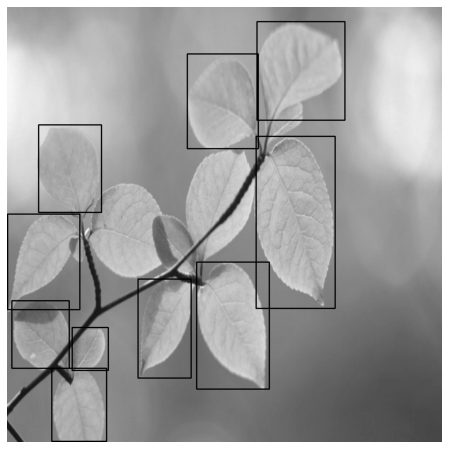

In [ ]:
it = iter(train_data_loader)
get_sample_image(it)

**Loading ResNet50 trained on COCO**

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 2  # 1 class (leaf) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [ ]:
model.to(device)
print("Model loaded")

Model loaded


In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 15

In [ ]:
loss_hist = Averager()
itr = 1

previous_epoch = 10
es_rate = 0

es_threshold = 2 # How many epochs without improvement to early stop


for epoch in range(num_epochs):
    loss_hist.reset()
    min_loss = 1000
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")
        
        itr += 1
                
            
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
    min_loss = loss_hist.value
    
    if min_loss < previous_epoch:
        previous_epoch = min_loss
        es_rate = 0
        
    else:
        if es_rate < es_threshold:
            es_rate += 1
        elif es_rate >= es_threshold:
            break
    print(f"Epoch #{epoch} loss: {loss_hist.value}")   

KeyboardInterrupt: ignored

**Validation (On data from Training)**

In [1]:
it = iter(valid_data_loader)
get_validation_image(it)

NameError: ignored